ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread


In [2]:
my_data_dir = 'C:\\Users\\Austy\\Downloads\\cell_images\\cell_images'

In [3]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [8]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
para_img= imread(para_cell)

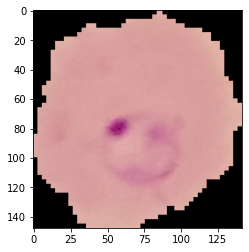

In [10]:
plt.imshow(para_img)

In [11]:
para_img.shape

(148, 142, 3)

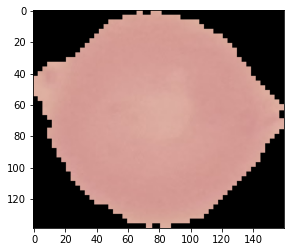

In [12]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Let's check how many images there are.**

In [13]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [14]:
len(os.listdir(train_path+'\\uninfected'))

12480

**Let's find out the average dimensions of these images.**

In [15]:
unifected_cell.shape

(139, 160, 3)

In [16]:
para_img.shape

(148, 142, 3)

In [17]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

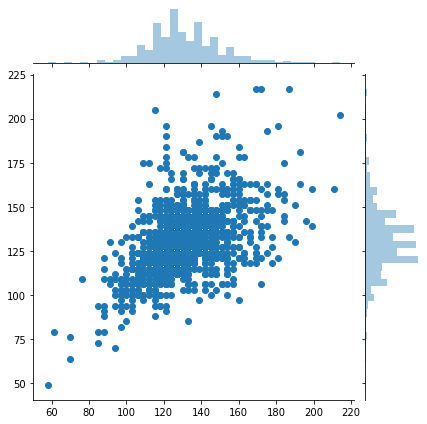

In [18]:
sns.jointplot(dim1,dim2)

In [19]:
np.mean(dim1)

130.92538461538462

In [20]:
np.mean(dim2)

130.75

In [21]:
image_shape = (130,130,3)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

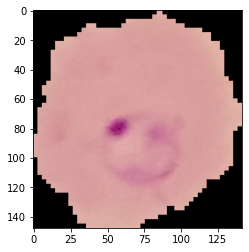

In [24]:
plt.imshow(para_img)

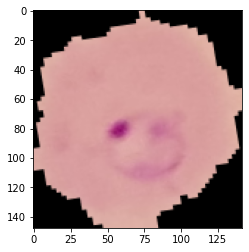

In [25]:
plt.imshow(image_gen.random_transform(para_img))

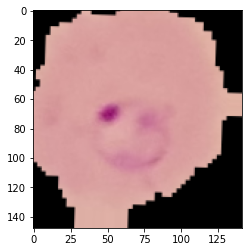

In [26]:
plt.imshow(image_gen.random_transform(para_img))

In [27]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [28]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [30]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [34]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module tensorflow.python.keras.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest') method of tensorflow.python.keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Arguments:
        directory: string, path to the target directory. It should contain one
          subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside
          each of the subdirectories directory tree will be included in the
          generator. See [this script](
            https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
              for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
         

In [35]:
batch_size = 16

In [36]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [37]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [38]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 196s 126ms/step - loss: 0.2722 - accuracy: 0.9090 - val_loss: 0.1880 - val_accuracy: 0.9331
Epoch 2/20
1560/1560 [==============================] - 98s 63ms/step - loss: 0.1787 - accuracy: 0.9445 - val_loss: 0.1708 - val_accuracy: 0.9477
Epoch 3/20
1560/1560 [==============================] - 100s 64ms/step - loss: 0.1612 - accuracy: 0.9480 - val_loss: 0.1591 - val_accuracy: 0.9469
Epoch 4/20
1560/1560 [==============================] - 99s 64ms/step - loss: 0.1602 - accuracy: 0.9492 - val_loss: 0.1580 - val_accuracy: 0.9481
Epoch 5/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.1562 - accuracy: 0.9501 - val_loss: 0.1521 - val_accuracy: 0.9496
Epoch 6/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.1548 - accuracy: 0.9509 - val_loss: 0.1532 - val_accuracy: 0.9485
Epoch 7/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.1501 - accuracy: 0.9521 - val_loss: 0.145

In [42]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

In [43]:
losses = pd.DataFrame(model.history.history)

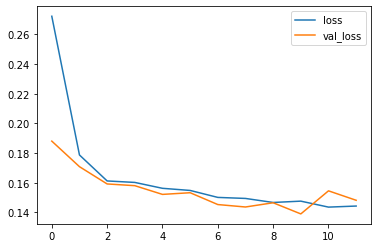

In [44]:
losses[['loss','val_loss']].plot()

In [45]:
model.metrics_names

['loss', 'accuracy']

In [46]:
model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.14770641922950745, 0.9453846216201782]

In [47]:
from tensorflow.keras.preprocessing import image

In [48]:
pred_probabilities = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [49]:
pred_probabilities

array([[2.1650470e-03],
       [1.4432838e-04],
       [1.7686719e-04],
       ...,
       [8.9221394e-01],
       [9.0905780e-01],
       [9.2535645e-01]], dtype=float32)

In [50]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [51]:
predictions = pred_probabilities > 0.5

In [52]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [53]:
from sklearn.metrics import classification_report,confusion_matrix

In [54]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1300
           1       0.93      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [55]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1199,  101],
       [  40, 1260]], dtype=int64)

In [56]:
para_cell

'C:\\Users\\Austy\\Downloads\\cell_images\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [57]:
my_image = image.load_img(para_cell,target_size=image_shape)

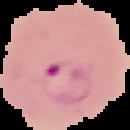

In [58]:
my_image

In [59]:
type(my_image)

PIL.Image.Image

In [60]:
my_image = image.img_to_array(my_image)

In [61]:
type(my_image)

numpy.ndarray

In [62]:
my_image.shape

(130, 130, 3)

In [63]:
my_image = np.expand_dims(my_image, axis=0)

In [64]:
my_image.shape

(1, 130, 130, 3)

In [65]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [66]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [67]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}